In [20]:
pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 4.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 5.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 5.2 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: tomlkit
    Found existing installation: tomlkit 0.11.1
    Uninstalling tomlkit-0.11.1:
      Successfully uninstalled tomlkit-0.11.1
Note: you may need to restart the kernel to use updated packages.


In [66]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import gradio as gr

In [68]:
df = pd.read_csv("/Users/macbookpro/Desktop/loan_data.csv")

In [70]:
df = df.dropna()

In [72]:
label_encoders = {}
for column in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

In [74]:
X = df.drop("Loan_Status", axis=1)
y = df["Loan_Status"]

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [78]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

In [36]:
print("Accuracy:", accuracy_score(y_test, model.predict(X_test)))

Accuracy: 0.8064516129032258


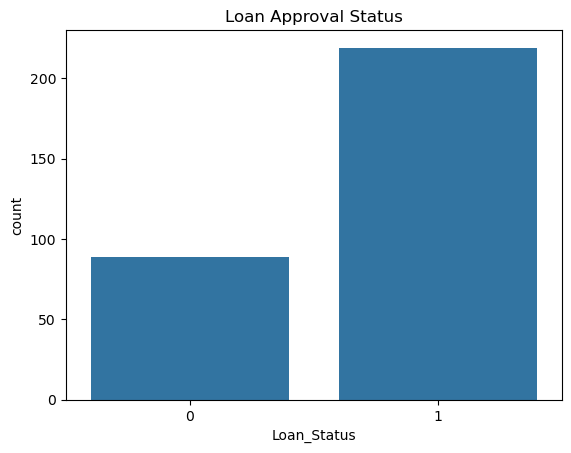

In [80]:
sns.countplot(x='Loan_Status', data=df)
plt.title("Loan Approval Status")
plt.show()

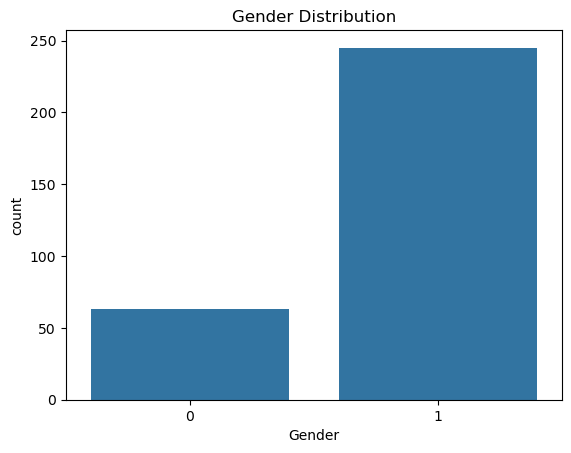

In [82]:
sns.countplot(x='Gender', data=df)
plt.title("Gender Distribution")
plt.show()

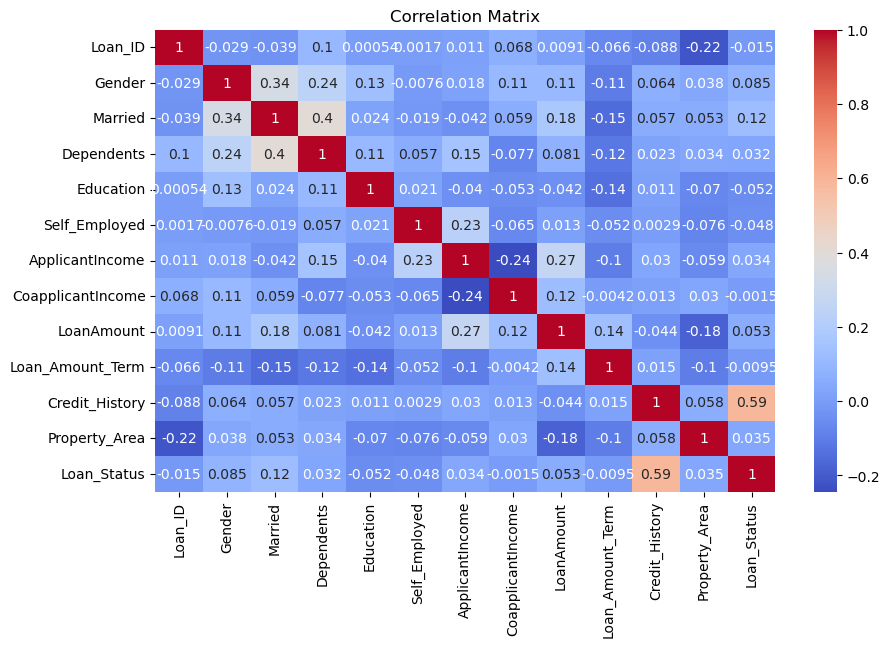

In [86]:
df_encoded = df.copy()
for col in df.select_dtypes(include='object').columns:
    df_encoded[col] = df_encoded[col].astype('category').cat.codes
plt.figure(figsize=(10, 6))
sns.heatmap(df_encoded.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [92]:
model = joblib.load("loan_model.joblib")
label_encoders = joblib.load("label_encoders.joblib")

categorical_cols = list(label_encoders.keys())
model_features = list(model.feature_names_in_)
numerical_cols = [col for col in model_features if col not in categorical_cols]

inputs = []
for col in categorical_cols:
    inputs.append(gr.Dropdown(choices=list(label_encoders[col].classes_), label=col))
for col in numerical_cols:
    inputs.append(gr.Number(label=col))

def predict_loan_status(*args):
    input_dict = {}
    idx = 0

    for col in categorical_cols:
        val = args[idx]
        input_dict[col] = label_encoders[col].transform([val])[0]
        idx += 1

    for col in numerical_cols:
        val = args[idx]
        if val is None:
            return "Please fill in all numerical values."
        input_dict[col] = val
        idx += 1

    input_df = pd.DataFrame([input_dict])[model_features]
    pred = model.predict(input_df)[0]

    return " Approved" if pred == 1 else " Rejected"

# Launch Gradio interface
gr.Interface(
    fn=predict_loan_status,
    inputs=inputs,
    outputs="text",
    title="Loan Approval Prediction",
    description="Enter applicant information to predict loan approval."
).launch(share=False)

* Running on local URL:  http://127.0.0.1:7863
* To create a public link, set `share=True` in `launch()`.
